## CROP YIELD ANALYSIS ASESSMENT

## INTRODUCTION

The goal is to analyze crop yield data to gain insights into agricultural performance and identify potential issues affecting crop production. By filtering out erroneous data, investigating major factors affecting crops per district, and examining average yields per hectare, I provide valuable information for decision-making and improving agricultural practices. Additionally, enumerator submissions will be assessed to ensure data integrity and reliability. This analysis seeks to contribute to the enhancement of agricultural productivity and sustainability.

- To analyze the data, I installed openpyxl to read and load the xlsx Excel file. I converted the three worksheets into data frames and merged them based on the '@caseid' column, which is a common column. First, I merged dataframe 1 and 2, and then merged this with dataframe 3. The resulting merged_df contains 2187 rows and 121 columns.

# Task 1: Merge the three works sheets using @case_id column

In [6]:
# Importing the necessary libraries
import pandas as pd
import pandasql as psql
import numpy as np
from pandasql import sqldf
import folium 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import shapiro, normaltest
from sklearn.cluster import DBSCAN
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Load the xlsx excel file
file_path = r"C:\Users\Emmanuel\OneDrive\Desktop\Crop Yield Analysis\Farm data.xlsx"

# Creating a list of all the three worksheets in the excel file
sheet_names = ['Box Placement', 'Wet Harvest', 'Dry Harvest']
dataframes = pd.read_excel(file_path, sheet_name= sheet_names)

# Merge the relevant sheets based on @case_id
box_placement = dataframes['Box Placement']
wet_harvest = dataframes['Wet Harvest']
dry_harvest = dataframes['Dry Harvest']

# Shape of the three dataframes before merge
box_placement.shape
wet_harvest.shape
dry_harvest.shape

print('Shape of box placement dataframe:', box_placement.shape)
print('Shape of wet_harvest dataframe:', wet_harvest.shape)
print('Shape of dry_harvest dataframe:', dry_harvest.shape)

# Perform the merge
merged_df = box_placement.merge(wet_harvest, on='@case_id', how='outer', suffixes=('_box', '_wet'))
final_merged_df = merged_df.merge(dry_harvest, on='@case_id', how='outer', suffixes=('', '_dry'))

# Display basic info about the merged dataframe
print('Shape of merged dataframe:', final_merged_df.shape)
print('\
First few rows of merged dataframe:')
final_merged_df.head()

Shape of box placement dataframe: (2356, 81)
Shape of wet_harvest dataframe: (2234, 24)
Shape of dry_harvest dataframe: (2222, 18)
Shape of merged dataframe: (2356, 121)
First few rows of merged dataframe:


client_name distance_to_water_body enumerator_comment_box  \
0           A                  0-5KM                   Done   
1           A         More_than_5_KM       successfuly done   
2           A         More_than_5_KM                     ok   
3           A         More_than_5_KM                     ok   
4           A         More_than_5_KM                     ok   

  expected_harvest_date farmer_in_list_or_control farmer_state_district  \
0            2022-05-27             farmer_listed               Katsina   
1            2022-05-27            control_farmer               Katsina   
2            2022-06-08            control_farmer               Zamfara   
3            2022-06-06            control_farmer               Zamfara   
4            2022-06-16            control_farmer               Zamfara   

  field_irrigated insured_crop intercropping  \
0              no        wheat            no   
1              no        wheat            no   
2              no        wheat            no   
3              no        wheat            no   
4              no        wheat            no   

  other_factors_that_affected_germination  ...  \
0         insufficient water for watering  ...   
1                  insufficient watering.  ...   
2                                    rain  ...   
3                             soil factor  ...   
4                             soil factor  ...   

  was_anything_added_or_removed_from_the_harvest_bag  \
0                                                NaN   
1                                                 no   
2                                                 no   
3                                                 no   
4                                                 no   

                       timeEnd                    timeStart  \
0                          NaN                          NaN   
1  2022-05-27T11:09:45.357000Z  2022-05-27T10:56:36.195000Z   
2  2022-06-01T11:25:45.374000Z  2022-06-01T11:18:01.603000Z   
3  2022-06-01T10:41:21.419000Z  2022-06-01T10:36:22.089000Z   
4  2022-06-01T09:51:49.265000Z  2022-06-01T09:46:32.212000Z   

  cannot_proceed_with_dry_harvest username  dry_harvest_comment   latitude  \
0                             NaN      NaN                  NaN        NaN   
1                             NaN   nig187                 Done  11.368059   
2                             NaN   nig040                   ok  12.147570   
3                             NaN   nig040                   ok  12.138754   
4                             NaN   nig040                   ok  12.138754   

   longitude altitude accuracy  
0        NaN      NaN      NaN  
1   7.568079   721.23     8.00  
2   6.714653   107.00     1.49  
3   6.686328   107.00     1.47  
4   6.686328   107.00     1.48  

[5 rows x 121 columns]

Since the data frames were merged using an outer join, the resulting merged data frame will have a larger possible dataset by row count. This merging creates new columns for the overlapping names, Columns in box_placement that overlap with columns in wet_harvest will receive the suffix _box for those from box_placement and _wet for those from wet_harvest.The suffixes=('', '_dry') means that if there are any overlapping columns between merged_df (which already includes columns from box_placement and wet_harvest) and dry_harvest, the columns from dry_harvest that overlap will receive the _dry suffix. The columns from merged_df that do not overlap will retain their names as they are.

If a column in both DataFrames has the exact same values for all rows, pandas will recognize that they are essentially the same data and will not create a new column for one of them. Instead, it will keep only one of them.

In [40]:
# Checking for columns that are common across all three worksheets

# Get column names from each dataframe as sets
box_placement_columns = set(box_placement.columns)
wet_harvest_columns = set(wet_harvest.columns)
dry_harvest_columns= set(dry_harvest.columns)

# Find common columns across all three dataframes
common_columns = box_placement_columns.intersection(wet_harvest_columns,dry_harvest_columns)

# Print common columns in a vertical manner
print("Common columns across all 3 worksheets:")
for col in common_columns:
    print(col)

Common columns across all 3 worksheets:
enumerator_comment
longitude
latitude
timeStart
altitude
accuracy
username
@case_id
timeEnd


# Merged data farm final_meged_df contains 2356 rows and 121 columns

# Task 2: Find enumerators entering incorrect data

Some indications of this are

     1. Crazy box dimensions
     2. False zero yields
     3. Dry weight exceeding wet weight
     4. Non-compliant data sets i.e no box dimension yet there is yield data captured. 
        Zero wet weight yield but greater than zero dry weight,harvest crop mixed with other crops 
     5. Note that other variables in the dataset might also explain funny results, check other variables.

In [63]:
# Define SQL query
# Checking enumerators who entered incorrect data
sql_query = """
SELECT 
    username,
    CASE 
        WHEN (box1_dim_8_by_5 IS NULL OR box1_dim_8_by_5 != 'yes') 
            AND (box2_dim_8_by_5 IS NULL OR box2_dim_8_by_5 != 'yes') 
            THEN 'Crazy box dimensions'
       
        WHEN (box1_wet_weight IS NULL AND box2_wet_weight IS NULL) 
            OR (COALESCE(box1_wet_weight, 0) + COALESCE(box2_wet_weight, 0)) = 0 
            THEN 'False zero yields'
       
       WHEN (COALESCE(box1_dry_weight, 0) + COALESCE(box2_dry_weight, 0)) > 
            (COALESCE(box1_wet_weight, 0) + COALESCE(box2_wet_weight, 0)) 
             THEN 'Dry weight exceeding wet weight'
        
       WHEN (box1_dim_8_by_5 IS NULL OR box2_dim_8_by_5 IS NULL) 
             AND (COALESCE(box1_wet_weight, 0) + COALESCE(box2_wet_weight, 0) > 0) 
             THEN 'Non-compliant data sets: No box dimension yet there is yield data captured'
        
        WHEN (COALESCE(box1_wet_weight, 0) = 0 AND COALESCE(box1_dry_weight, 0) > 0) 
             OR (COALESCE(box2_wet_weight, 0) = 0 AND COALESCE(box2_dry_weight, 0) > 0) 
             THEN 'Non-compliant data sets: Zero wet weight yield but greater than zero dry weight'
        
    END AS issue

FROM 
    final_merged_df
GROUP BY 
    username
HAVING 
    issue IS NOT NULL;
"""

# Execute the SQL query on the DataFrame
result_df = sqldf(sql_query, locals())
result_df

username                            issue
0    nig022                False zero yields
1    nig024             Crazy box dimensions
2    nig033             Crazy box dimensions
3    nig035             Crazy box dimensions
4    nig075                False zero yields
5    nig108  Dry weight exceeding wet weight
6    nig109                False zero yields
7    nig111  Dry weight exceeding wet weight
8    nig114                False zero yields
9    nig148                False zero yields
10   nig168  Dry weight exceeding wet weight
11   nig175             Crazy box dimensions
12   nig186             Crazy box dimensions

- In the above code, we defined an SQL query, incorporating the conditions stated to find enumerators keying in incorrect data.

- In the first condition, the first line of code, the condition provided will not incorporate null values in its evaluation, as it explicitly checks for the string 'yes'. To incorporate null values in such a way that they are treated as a condition leading to 'Crazy box dimensions', we modify our condition to explicitly check for null values.

- In the second condition and third and fourth conditions, COALESCE ensures the condition captures cases where the weight of either box is null and treats them as 0. We use COALESCE to replace NULL with 0, and therefore treat null values as 0 in this comparison.

# From the code output, 13 enumerators entered incorrect data.

# Task 3:  Use the box placement latitude and longitude, to come up with a spatial distribution of the data points on a map (you can use tools such as QGIS, Google Maps, ArcGIS or whichever tool you deem fit). Consider this as well when assessing enumerator performance

In [66]:
# Check for missing values first in lat and lon columns in box_placement df
missing_latitude = box_placement["latitude"].isnull().sum()
missing_longitude= box_placement["longitude"].isnull().sum()

print(f"Missing values in latitude column: {missing_latitude}")
print(f"Missing values in longitude column: {missing_longitude}")

Missing values in latitude column: 0
Missing values in longitude column: 0


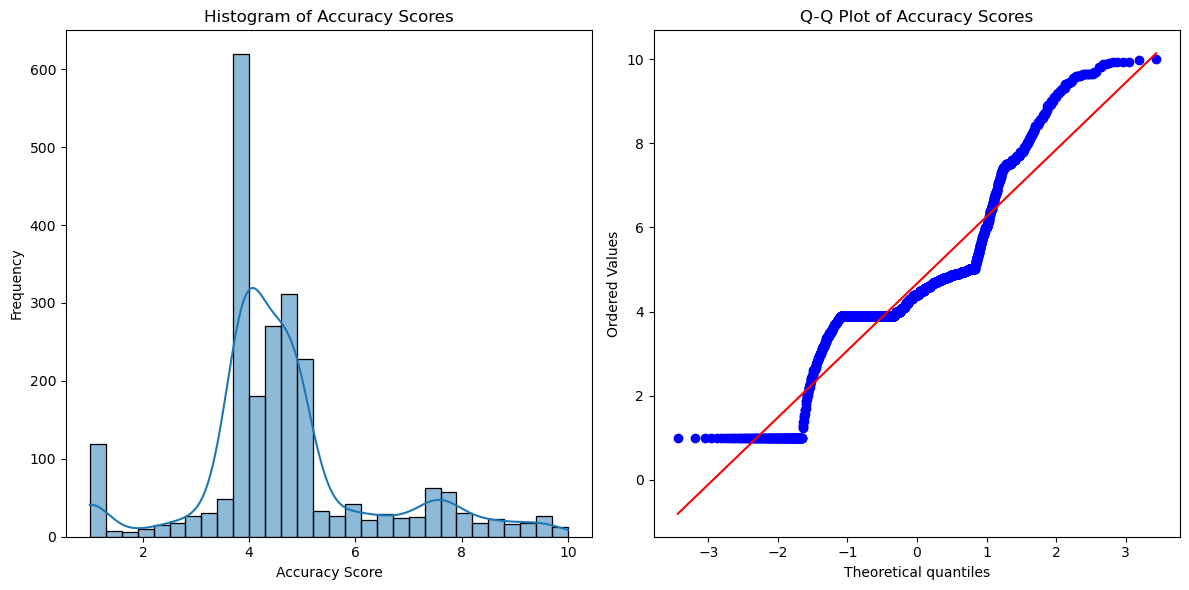

In [93]:
# Visualizing the distribution of the accuracy scores
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(box_placement['accuracy'], bins=30, kde=True)
plt.title('Histogram of Accuracy Scores')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(box_placement['accuracy'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Accuracy Scores')

plt.tight_layout()
plt.show()

In [95]:
# Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(box_placement['z_score'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}')

# D'Agostino and Pearson's test
k2, p_value = normaltest(box_placement['z_score'])
print(f'D\'Agostino\'s K^2 Test: Statistic={k2}, p-value={p_value}')

Shapiro-Wilk Test: Statistic=0.881045937538147, p-value=3.371221424697216e-39
D'Agostino's K^2 Test: Statistic=233.35807364853088, p-value=2.1229421187009104e-51


In [ ]:
- As per the results of the normality scores, our accuracy score results is not normally distributed.

In [100]:
#To assess enumerator performance, we use the accuracy score values 

# Get the minimum and maximum values of the column
min_value = box_placement['accuracy'].min()
max_value = box_placement['accuracy'].max()

# Display the results
print(f"Minimum value in 'accuracy' column: {min_value}")
print(f"Maximum value in 'accuracy' column: {max_value}")

Minimum value in 'accuracy' column: 1.0
Maximum value in 'accuracy' column: 10.0


- Since our accuracy score values range from 1 to 10. We can ssign the values into following bins
if accuracy > 1 and accuracy <=3: Low accuracy 
if accuracy > 4 but <=7: Medium accuracy
if accuracy > 7 : High accuracy

In [96]:
# Initialize a map centered around the average location
center_lat = box_placement['latitude'].mean()
center_lon = box_placement['longitude'].mean()
map = folium.Map(location=[center_lat, center_lon], zoom_start=10)

 # Define a function to get color based on accuracy score
def get_color(accuracy):
    if accuracy > 1 and accuracy <=3:
        return 'red'      # Low accuracy
    
    elif accuracy > 4 and accuracy <= 7:
        return 'orange'   # Medium accuracy
    
    else:
        return 'green'    # High accuracy


# Add points to the map
for _, row in box_placement.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Username: {row['username']}<br>Accuracy: {row['accuracy']}",
        icon=folium.Icon(color=get_color(row['accuracy']))
    ).add_to(map)
    
# Display the map
map

Mapping data points based on latitude and longitude helps assess enumerator performance by visually identifying patterns, inconsistencies, or outliers in their data collection locations.

- Data Verification: Maps provide a straightforward way to verify if data points align with expected areas. Any points significantly outside the intended region might need investigation for validity.

- Comparison with Geographic Points: By analyzing the accuracy scores alongside latitude and longitude, you can assess if there are specific regions or areas where data collection was particularly problematic or exceptionally accurate.

- Coverage Check: By viewing data points on a map, you can see if enumerators covered the assigned area effectively. Gaps or clustering in certain areas might indicate incomplete data collection or over-sampling in certain regions.

- The accuracy score values indicate the level of precision or correctness of the data collected at each geographic point. Accuracy scores typically represent how closely the recorded data corresponds to the true or actual values. They also reflect the quality of the data collected by the enumerators.

-The above map displays the spatial distribution of data points on a map using the longitude and latitude columns.
-The red color coded data points represent enumerators with a low accuracy. 
-The orange color coded data points represent enumerators with a medium/fair accuracy.
-The green color coded data points represent enumerators with a high accuracy.

Lower Scores (e.g., 1): indicate lower accuracy or higher error rates, suggesting that the data collected at these points may not be reliable. Higher Scores (e.g., 10): indicate higher accuracy, suggesting that the data collected is closer to the true value and more reliable.

if an observation has a low accuracy score, it might warrant further investigation or exclusion from certain analyses.

In [101]:
# Count the number of points with low accuracy (red markers)
low_accuracy_count = box_placement[(box_placement['accuracy'] > 1) & (box_placement['accuracy'] <= 3)].shape[0]

print(f"Number of points with low accuracy (red markers): {low_accuracy_count}")

Number of points with low accuracy (red markers): 79


# Z-score Analysis

-Z-scores are a statistical measure that indicates how many standard deviations a data point is from the mean of a dataset. They provide insight into the relative standing of a value within a distribution. 

-Small Z-scores (between -1 and 1): These indicate that the data points are relatively close to the mean and are generally considered to be typical values within the distribution.
Moderate Z-scores (between -2 and -1 or 1 and 2): These suggest that the data points are further away from the mean, indicating they are less common but not necessarily outliers.

-Large Z-scores (less than -2 or greater than 2): These values are typically considered outliers. For example, a Z-score of +3 or -3 indicates that the data point is three standard deviations away from the mean and is quite rare.

-However, since Z-scores interpretation should take into account the context of the data and the distribution shape: 

-Non-Normal Distribution: In distributions that are skewed or have heavy tails, the interpretation may differ. Z-scores can still help identify extremes, but the expected percentages may not apply. Our accuracy score distribution show a non-normal distribution as evidenced by the shapiro wilk and D'Agostino's K^2 Test.

-In a normal distribution, approximately 68% of the data points will have Z-scores between -1 and +1, about 95% will fall between -2 and +2, and about 99.7% will lie between -3 and +3.

In [17]:
# Assuming coordinates is a list of [latitude, longitude] pairs
dbscan = DBSCAN(eps=0.01, min_samples=5)  # Adjust eps as needed
labels = dbscan.fit_predict(coordinates)

# Initialize the map centered around the data points
map_center = [box_placement['latitude'].mean(), box_placement['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=10)

# Mark points on the map
for i, row in box_placement.iterrows():
    # Check if the point is labeled as an outlier
    if labels[i] == -1:
        # Mark as outlier with a red icon
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Outlier - username: {row['username']}",
            icon=folium.Icon(color='red')
        ).add_to(map)
    else:
        # Non-outliers with default markers
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"username: {row['username']}"
        ).add_to(map)

# Display the map
map

-  The code applies DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering to a set of geographical coordinates and visualizes the results on a map using Folium.
DBSCAN is an algorithm that groups points close to each other and labels points that don’t belong to any group as outliers (noise).

eps=0.01 defines the maximum distance between two points to be in the same cluster (tunable based on data density).
min_samples=5 sets the minimum number of points needed to form a dense region (cluster).

fit_predict(coordinates) applies DBSCAN to the coordinates (latitude and longitude pairs) and returns a labels array where each point is either assigned a cluster label (e.g., 0, 1, 2…) or labeled -1 if it's considered an outlier.

Map Initialization:

A map is created with Folium, centered on the mean latitude and longitude of all data points, using zoom_start=10 to set the initial zoom level.


Marker Plotting:

The code iterates over each row in box_placement (assumed to contain columns for latitude, longitude, and username).
For each point:

If labels[i] is -1, it’s marked as an outlier, and a red marker is added to the map at that location with a popup indicating it’s an outlier, along with the username.

If labels[i] is not -1, the point is considered part of a cluster and plotted with a standard marker that includes only the username.

The resulting map shows all the geographical data points, color-coded based on their clustering status:

Outliers (noise) are in red, making them easy to spot as potential areas of interest or irregularities.
Clustered points use default markers, making it possible to distinguish dense regions from isolated points.

# Task 4:  Compute the average yield in Mt/Ha for each observation, using the dry weight

In [15]:
# Convert dry weight to Mt/Ha (dry weight is in kilograms) # 1 metric ton = 1000 kilograms
final_merged_df['dry_yield_mt_ha'] = (final_merged_df['box1_dry_weight_confirmation'] + final_merged_df['box2_dry_weight_confirmation']) / 1000

# Using @case_id to group the average yield for each observation then compute the average yield for each observation separately
average_yield_per_observation = final_merged_df.groupby('@case_id')['dry_yield_mt_ha'].mean()
average_yield_per_observation.head()

@case_id
0001fc96-37b7-4cb6-80f7-af619bfc832d         NaN
0011ce18-eeba-4b51-b2db-37849dc7d3c4    0.013125
0035c4de-9d70-4fd0-9d04-f9da861888c3    0.003200
003cfb75-4b9d-4228-974b-72763b55c82f    0.003735
0072354d-d725-4eaf-a6cf-22b96fe45403    0.005850
Name: dry_yield_mt_ha, dtype: float64

# Task 5: Create filters in a new column or columns to determine which types of yields we should consider outliers or errors and fill those columns so that we can filter the outliers on and off as needed. (if using code, clearly show these filters)

Outlier Criteria for Yields:

Statistical Outliers: Outliers can be values that deviate significantly from the statistical norms in your dataset, such as values beyond 1.5 times the interquartile range (IQR) or a certain number of standard deviations from the mean.


In [27]:
# IQR-based outlier detection
Q1 = final_merged_df['dry_yield_mt_ha'].quantile(0.25)
Q3 = final_merged_df['dry_yield_mt_ha'].quantile(0.75)

IQR = Q3 - Q1

# Define bounds for typical values (1.5 times the IQR range is a common approach)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add a column to flag outliers based on IQR
final_merged_df['outlier_yields'] = (final_merged_df['dry_yield_mt_ha'] < lower_bound) | (final_merged_df['dry_yield_mt_ha'] > upper_bound)

# Display the first few values in the 'outlier_yields' column for flagged outliers
final_merged_df.loc[final_merged_df['outlier_yields'] == True, 'outlier_yields'].head()

281    True
282    True
283    True
284    True
285    True
Name: outlier_yields, dtype: bool

In [41]:
# Calculate the average yield in metric tonnes of outlier yields
average_outlier_yield = final_merged_df.loc[final_merged_df['outlier_yields'], 'dry_yield_mt_ha'].mean()

# Display the result
print("Average Yield of Outliers (mt/ha):", average_outlier_yield)

Average Yield of Outliers (mt/ha): 0.02984335294117647


In [43]:
# Count the number of outliers in the 'outlier_yields' column
outlier_count = final_merged_df['outlier_yields'].sum()
outlier_count

85

-The above code utilizes IQR, a statistical tool for measuring dispersion used to identify outliers in a dataset. It represents the middle 50% of the   data and is calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1).

Q3 - The value below which 75% of the data fall.
Q1 -The value below which 25% of the data fall.

A column is added to flag outliers based on IQR. Values satisfying this criterion are evaluated as True. The outlier count is 85.

# Task 6: Identify major problems affecting the crops per district or state. Use box1_problem column. Is there consistency?

In [32]:
# Count the number of unique districts
num_districts = final_merged_df['farmer_state_district'].nunique()

# Display the result
print("Number of districts:", num_districts)

Number of districts: 15


In [29]:
# Identifying crop problems in the the farmer state districts

# Group the data by district and count occurrences of each problem
problem_counts = final_merged_df.groupby(['farmer_state_district', 'box1_problem']).size().reset_index(name='count')

# Display the aggregated data
print(problem_counts)

    farmer_state_district                                 box1_problem  count
0                 Adamawa     animal_cattle_encroachment late_planting      1
1                 Adamawa                                      drought     11
2                 Adamawa                               drought others      1
3                 Adamawa                                        flood      2
4                 Adamawa                                late_planting     35
..                    ...                                          ...    ...
141                  Yobe                          weeds late_planting      1
142               Zamfara                                      drought      5
143               Zamfara                     drought poor_germination      6
144               Zamfara  drought poor_germination locust_infestation     33
145               Zamfara                             poor_germination      3

[146 rows x 3 columns]


In [34]:
# Find the most and least occurring problems within each district
most_occurring_problems = problem_counts.loc[problem_counts.groupby('farmer_state_district')['count'].idxmax()]

# Display the results
print("Most Occurring Problems by District:")
print(most_occurring)

Most Occurring Problems by District:
    farmer_state_district                                 box1_problem  count
4                 Adamawa                                late_planting     35
34                 Bauchi                             poor_germination     81
47                  Borno                                late_planting     26
53                  Gombe                                      drought      2
58                 Jigawa                         late_planting others      4
65                 Kaduna                             poor_germination     42
77                   Kano                             poor_germination     10
84                Katsina                             poor_germination     24
101                 Niger                                late_planting    160
116                Sokoto                                late_planting     18
128                Taraba                             poor_germination     44
136                  Yobe  

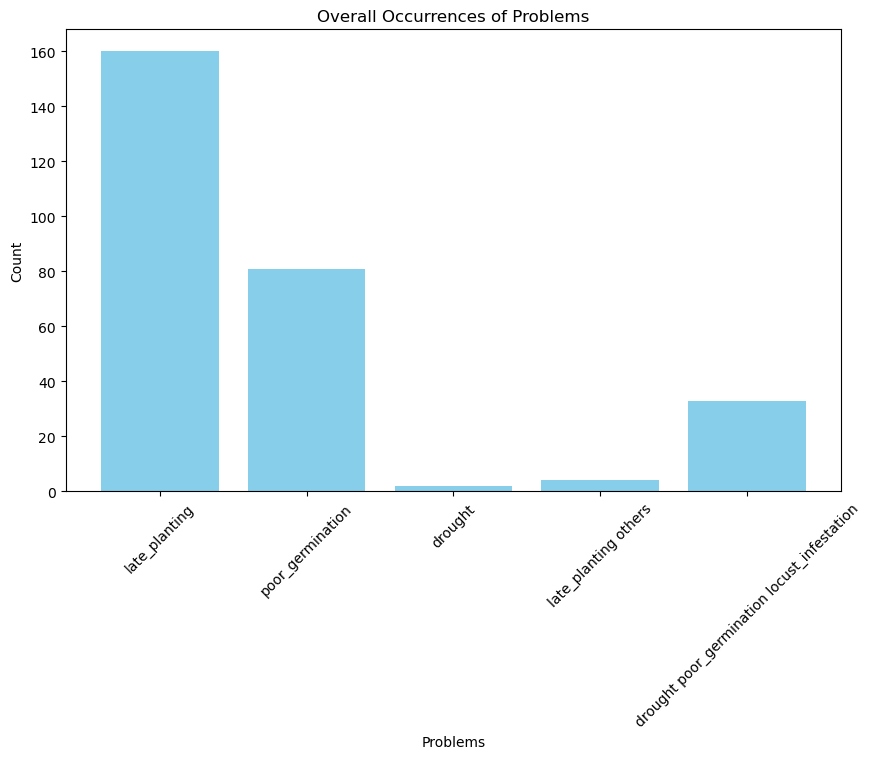

In [35]:
# A bar plot to visualize the counts of each problem across districts, helping identify dominant issues quickly

plt.figure(figsize=(10, 6))
plt.bar(most_occurring_problems['box1_problem'],most_occurring_problems['count'], color='skyblue')
plt.title('Overall Occurrences of Problems')
plt.xlabel('Problems')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Late planting and poor germination are the most common problems across the districts.
Crops have specific growth cycles that need to be adhered to for optimal yields.

Late planting can lead to a mismatch in the timing of flowering and harvest, affecting overall crop performance.

# Task 7: Write a short and easy-to-understand report to share with your supervisor. The report should:
        -  Show what you think the average yields per hectare in Metric tonnes are, having filtered out/cleaned erroneous data.
        -  Explain the erroneous data you filtered/cleaned out and how (be clear, use bullet point type explanations)
        -  Show the major factors/problems affecting the crops per district and determine if there are any inconsistencies 
        -  Explain if you think any enumerators submitted data that was suspicious to the level of needing to be terminated. 

In [42]:
# Calculate the average yield for non-outlier yields
average_non_outlier_yield = final_merged_df.loc[final_merged_df['outlier_yields'] == False, 'dry_yield_mt_ha'].mean()

# Display the result
print("Average Yield of Non-Outliers (mt/ha):", average_non_outlier_yield)

Average Yield of Non-Outliers (mt/ha): 0.007441805084745763


In [46]:
# Calculate the sum of non-outlier yields
total_non_outlier_yield = final_merged_df.loc[final_merged_df['outlier_yields'] == False, 'dry_yield_mt_ha'].sum()

print("Total Yield of Non-Outliers (mt):", total_non_outlier_yield)

Total Yield of Non-Outliers (mt): 14.928261


# Report on Crop Yield Analysis

### Average Yields per Hectare:

After filtering out erroneous data, the average yield per hectare in Metric tonnes is estimated to be 0.007441805084745763 Mt/Ha.


### Erroneous Data Filtering:

- Removed box dimensions either undefined (NULL) or not confirmed as valid ('yes'). 

- Removed data points with zero yields and null values for both wet weight and dry weight, as these are likely errors in data entry or recording.

- Excluded data points where the dry weight exceeded the wet weight, as this is physically impossible and indicative of measurement errors.

- Removed data points where at least one box dimension is missing (NULL), while at the same time, there is captured yield data. I


### Major Factors/Problems Affecting Crops per District:

- Identified major problems affecting crops per district based on the 'box1_problem' column such as but not limited to late planting,poor germination, animal cattle encroachment, drought, floods, weeds

- Found inconsistencies in problem reporting across districts, indicating potential data collection issues or varying agricultural practices.

### Suspicious Data Submission by Enumerators:

Detected suspicious data submitted by some enumerators, with the help of accuracy scores

### Recommendation:

- Further investigation and evaluation of enumerator performance needs to be done to determine if termination is necessary to maintain data integrity.

### Conclusion:

- The analysis provides valuable insights into crop yield trends, identifies potential data quality issues,
- Further collaboration with enumerators and stakeholders is recommended to address discrepancies and ensure accurate reporting of agricultural data.
